# An analysis of models of biofilm formation under predation stress
## Author: Stephen Williams

In this script, we will attempt to characterise the model presented in Seiler et. al. 2017.
In particular, we will assess whether the model presented is identifiable. If not, what modifications are required given the existing data to make it so.

In [1]:
# Imports and libraries
using DifferentialEquations
using Plots
using Distributions
using Interpolations
using NLopt
using Dierckx
using SpecialFunctions
using Random
using StructuralIdentifiability
using Logging,Printf # Output options
using Base.Threads

# Set the options
gr(); # Set the figure generation settings
Logging.disable_logging(Logging.Info); # Set the figure generation settings

1. Here we will solve an example case of the model, using the parameters presented in the original paper.

In [2]:
# Solve the ODE normally

## Input definitions
# du - output vector
# u - input vector
# theta - parameters
# t - time
function biofilm_predators(du, u, theta, t)
    # Extract the different species
    C, F, B, S, A = u
    # Extract parameters
    r2, r3, r4, r5, e23, e4, e5, H2, H3, H4, H5, chioff, a, chimax, chimin = theta
    # Other required values
    sig = 8/3 # Volume/surface area. 
    chion = (a*chimax + chimin*B)/(a+B) # Bind-on rate
    # Calculate the ODEs to output
    du[1] = - r2*(C/(C+H2))*F/e23 - sig*r3*(C/(C+H3))*B/e23
    du[2] = r2*(C/(C+H2))*F - r4*(F/(F+H4))*S - chion*F*sig + chioff*B*sig
    du[3] = r3*(C/(C+H3))*B - r5*(B/(B+H5))*A + chion*F - chioff*B
    du[4] = e4*r4*(F/(F+H4))*S 
    du[5] = e5*r5*(B/(B+H5))*A
    # Output array for solving
    return du
end

# Set the values required for the ODE solver
theta = [0.21,0.007,0.12,0.09, # growth rates
         0.2,0.5,0.5, # Efficiencies
         1.0,1.0,1.0,0.1, # Half saturations
         0.005,0.01,0.05,0.005] # Attatchment parameters
u0 = [1.0,1.0,0.0,0.05,0.01] # IVP
tspan = (0.0, 24.0) # Time span of solution
sample_frequency = 0.1
output_times = 0.0:sample_frequency:24.0 # Times at which to output the solutions
N_times = length(output_times)
  
# Solve the ODE system
prob = ODEProblem(biofilm_predators, u0, tspan, theta)
sol = solve(prob, Tsit5(), saveat=output_times)
  
# Plot the resulting data
scatter(sol.t, sol[1,:], label="C")
scatter!(sol.t,sol[2,:], label="F")
scatter!(sol.t,sol[3,:], label="B")
scatter!(sol.t,sol[4,:], label="S")
scatter!(sol.t,sol[5,:], label="A")

savefig("figures/popPlot.png");

2. The first step in characterising the model is to determine whether it is structurally identifiable. This is a prerequisite of any practical identifiability and will determine whether there is any immediate issues which are present

In [3]:
# Structural Identifiability
# The code can be a bit slow, optional run with this logical
perform_SI = false

if perform_SI == true

    # ODE model 0
    # All of the state variables are known
    ode0 = @ODEmodel(
        # These encode for the ODEs that describe the dynamics
        x1'(t) = -(1/eb)*( r2*x1(t)/(H2 + x1(t))*x2(t) + r3*x1(t)/(H3 + x1(t))*x3(t) ),
        x2'(t) = r2*x1(t)/(H2 + x1(t))*x2(t) + chi32*x3(t) - r4*x2(t)/(H4 + x2(t))*x4(t) - (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x3'(t) = r3*x1(t)/(H3 + x1(t))*x3(t) - chi32*x3(t) - r5*x3(t)/(H5 + x3(t))*x5(t) + (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x4'(t) = e4*r4*x2(t)/(H4 + x2(t))*x4(t),
        x5'(t) = e5*r5*x3(t)/(H5 + x3(t))*x5(t),
        # These encode for the available measured state variables in the system
        y1(t) = x1(t),
        y2(t) = x2(t),
        y3(t) = x3(t),
        y4(t) = x4(t),
        y5(t) = x5(t)
    )

    println("Assessing case 0")
    out0 = assess_identifiability(ode0)
    println(out0)

    # ODE model 1
    # Measurements of the system are known for the planktonic,
    # biofilm, ciliates and the ameoba.
    ode1 = @ODEmodel(
        # These encode for the ODEs that describe the dynamics
        x1'(t) = -(1/eb)*( r2*x1(t)/(H2 + x1(t))*x2(t) + r3*x1(t)/(H3 + x1(t))*x3(t) ),
        x2'(t) = r2*x1(t)/(H2 + x1(t))*x2(t) + chi32*x3(t) - r4*x2(t)/(H4 + x2(t))*x4(t) - (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x3'(t) = r3*x1(t)/(H3 + x1(t))*x3(t) - chi32*x3(t) - r5*x3(t)/(H5 + x3(t))*x5(t) + (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x4'(t) = e4*r4*x2(t)/(H4 + x2(t))*x4(t),
        x5'(t) = e5*r5*x3(t)/(H5 + x3(t))*x5(t),
        # These encode for the available measured state variables in the system
        y1(t) = x2(t),
        y2(t) = x3(t),
        y3(t) = x4(t),
        y4(t) = x5(t)
    )

    println("Assessing case 1")
    out1 = assess_identifiability(ode1)
    println(out1)

    # ODE model 2
    # Measurements of the system are known for the
    # biofilm, ciliates and the ameoba.
    ode2 = @ODEmodel(
        # These encode for the ODEs that describe the dynamics
        x1'(t) = -(1/eb)*( r2*x1(t)/(H2 + x1(t))*x2(t) + r3*x1(t)/(H3 + x1(t))*x3(t) ),
        x2'(t) = r2*x1(t)/(H2 + x1(t))*x2(t) + chi32*x3(t) - r4*x2(t)/(H4 + x2(t))*x4(t) - (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x3'(t) = r3*x1(t)/(H3 + x1(t))*x3(t) - chi32*x3(t) - r5*x3(t)/(H5 + x3(t))*x5(t) + (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x4'(t) = e4*r4*x2(t)/(H4 + x2(t))*x4(t),
        x5'(t) = e5*r5*x3(t)/(H5 + x3(t))*x5(t),
        # These encode for the available measured state variables in the system
        y1(t) = x3(t),
        y2(t) = x4(t),
        y3(t) = x5(t)
    )

    println("Assessing case 2")
    out2 = assess_identifiability(ode2)
    println(out2)

    # ODE model 3
    # Measurements of the system are known for the
    # biofilm, ciliates and the ameoba.
    # Model is re-parameterised with eb absorbed into r2 and r3 (i.e. r2' = r2/eb) to allow global identifiability
    ode3 = @ODEmodel(
        # These encode for the ODEs that describe the dynamics
        x1'(t) = -(r2*x1(t)/(H2 + x1(t))*x2(t) + r3*x1(t)/(H3 + x1(t))*x3(t) ),
        x2'(t) = r2*x1(t)/(H2 + x1(t))*x2(t) + chi32*x3(t) - r4*x2(t)/(H4 + x2(t))*x4(t) - (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x3'(t) = r3*x1(t)/(H3 + x1(t))*x3(t) - chi32*x3(t) - r5*x3(t)/(H5 + x3(t))*x5(t) + (a*chiMax + chiMin*x2(t))/(a+x2(t)),
        x4'(t) = e4*r4*x2(t)/(H4 + x2(t))*x4(t),
        x5'(t) = e5*r5*x3(t)/(H5 + x3(t))*x5(t),
        # These encode for the available measured state variables in the system
        y1(t) = x2(t),
        y2(t) = x3(t),
        y3(t) = x4(t),
        y4(t) = x5(t)
    )

    println("Assessing case 3")
    out3 = assess_identifiability(ode3)
    println(out3)

end

# find_identifyable_functions()

As a result, we can see that if *all* of the state variables for the system are known that the full model is globally identifiable. 

However, upon losing access to the measurement on the carbon source the following variables cannot be uniquely determined: H2, H3, eb.

If we further reduce our informational availibility then our situation is made no worse. 
If we remove one of the unidentifiable variables (in effect reparameterising the system; this is replacing H2,H3 with H2'=eb*H2 and similarly for H3), then we recover the global identifiability of the system even if the carbon content remains unmeasured: however, the wrongskin of this has a co-rank greater than 1, meaning multiple repeat experiments may need to be performed.

Note on case 3 (using https://maple.cloud/app/6509768948056064/) -- this is an impemetation of the SIAN software which determines an upper bound on the # of experiments required.. this shows case 3 is actually single-experiment globally identifiable.

3. Next, in order to assess whether the parameters are practically identifiable, we can do the following.
   
- We will need to generate a set of synthetic data. From this data we can then look at the log-likelihood, via. MLE, for given sets of parameters. 
- Optimising the MLE value to give the "most likely" parameter sets to generate this data. 
- We can then look at a plot of the MLE around this optimal value (holding other parameters constant at nominal) to determine whether the parameters are particularly sensitive given a certain level of data to being determined.
- By comparing to a (check this with the example code?) t-distribution, we can predict the uncertainty in the predictions.

Note: the data will be generated accoring to a log-normal noise distribution, since at various times the populations are very "small", non-log-normal noise could lead to non-physical values here. Some other kind of proportional noise could work too.


In [4]:
# Generate synthetic data - proportional noise

# Constants
mu = 0 # LN "mean"
sigma = 0.05 # LN "variance"
N_samples = 1000 # Number of synthetic samples

# Preallocate storage for the output
N_times = length(sol[1, :])
modified_data = zeros(5,N_times,N_samples)

# Loop through the various species to generate all the synthetic data-points
@threads for type_species in 1:5
    for n in 1:N_samples
        for s in 1:N_times
            modified_data[type_species,s,n] = sol[type_species, s] * exp.(mu.+sigma*randn())
        end
    end
end

We now have a synthetic dataset, corrupted by a proportional (log-normal) noise. We can now begin to attempt parameter estimation on our synthetic set.

In [5]:
# Define the required set of functions for optimising

# Create a function, the output of which is the "base" function.
function model(t,theta,u0)
    tspan = (t[1],t[end])
    prob = ODEProblem(biofilm_predators, u0, tspan, theta)
    return solve(prob, Tsit5(), saveat=t)
end

# This calculates the log-likihood of the data given a pre-specified distribution
function loglhood(data,theta,noise_sig,u0,t)
    y = model(t,theta,u0) # Get the model output for a given parameter set
    dist = LogNormal(0,noise_sig) # This may need to be modified?
    output = 0 # Preallocate a store for the llhd
    for i in 1:5 # Loop through the species
        for n in N_samples # Loop through the random samples
            for t in N_times # Loop through the time-points
                if y[i,t] > 0  # If the species population at  time-t is non-zero count it -- this prevents inf errors for cases where species arent present
                    e = Distributions.loglikelihood(dist,data[i,t,n]./y[i,t]) # Get pdf of given deviation given dist
                    output = output + e
                end
            end
        end
    end
    return output
end

# This function optimises the function fun wrt parameters theta0, with bounds lb and ub.
function Optimise(fun,theta0,lb,ub)    
    tomax = (θ,∂θ)->fun(θ)
    opt = Opt(:GD_STOGO,length(theta0)) # (*)
    opt.max_objective = tomax
    opt.lower_bounds=lb; opt.upper_bounds=ub;
    opt.maxtime = 100 # Seconds to timeout
    result = optimize(opt,theta0)
    return result[[2,1]]
end

# This is the function which is actually optimised
function funmle(theta)
    return loglhood(data,theta,noise_sig,u0,output_times)
end

## Set up the system to be optimised

data = modified_data # Set the data to be fit to

u0 = [1.0,1.0,0.0,0.05,0.01] # IVP
tspan = (0.0, 24.0) # Time span of solution
output_times = 0.0:sample_frequency:24.0 # Times at which to output the solutions
noise_sig = 0.05 # Guess the variance of the noise in the data

theta = [0.21,0.007,0.12,0.09, # Growth rates
         0.2,0.5,0.5, # Efficiencies
         1.0,1.0,1.0,0.1, # Half saturations
         0.005,0.01,0.05,0.005] # Attatchment parameters

theta0 = theta # Copy the baseline(/true) parameters 
modification_scaling = 0.3 # Percent change range for uniform scaling of true parameters
scalings = (1 .+ modification_scaling*2*(rand(length(theta)).-0.5))
theta0 = theta0 .* scalings # Initial guess for parameters
delta = 0.5 # Scale the range with which to check params
lb = theta.*(1-delta) # Lower bound
ub = theta.*(1+delta) # Upper bound

(xopt,fopt) = Optimise(funmle,theta0,lb,ub) # Fit funmle to the data

# Generate solutionsfor the true, and the initial guess, parameter sets
prob1 = ODEProblem(biofilm_predators, u0, tspan, xopt)
sol_fit1 = solve(prob1, Tsit5(), saveat=output_times)
prob2 = ODEProblem(biofilm_predators, u0, tspan, theta)
sol_fit2 = solve(prob2, Tsit5(), saveat=output_times)

# Plot of the synthetic data vs. the fit
plot_comparison = true
if plot_comparison
    plt = plot(0,0)
    for ii in range(1,5)
        for jj in 1:10
            scatter!(output_times,data[ii,:,jj],legend=false)
        end
        plot!(output_times,sol_fit2[ii,:],lw=4,legend=false)
    end
    savefig("figures/comaprisonPlot.png");
end

# Plot the "residual" analog.
plot_residuals = true
if plot_residuals
    plt = plot(0,0)
    for jj in 1:floor(Int32,length(data[1,1,:])/10)
        plot!(output_times,data[1,:,jj]./sol_fit2[1,:])
    end
    savefig("figures/residualPlot.png");
end

# Print the outcome parameters, their % difference to the true, and the initial guess
print_results = true
if print_results

    println("Optimised parameters vs original")
    println(round.(xopt; sigdigits=3))
    println(round.(theta; sigdigits=3))
    
    println("% compared to true")
    println(round.(100*(xopt-theta)./theta; sigdigits=2))

    println("% compared to guess")
    println(round.(100*(xopt-theta0)./theta0; sigdigits=2))
    
end


Optimised parameters vs original
[0.184, 0.007, 0.15, 0.09, 0.25, 0.392, 0.467, 0.72, 0.823, 0.824, 0.1, 0.005, 0.01, 0.05, 0.005]
[0.21, 0.007, 0.12, 0.09, 0.2, 0.5, 0.5, 1.0, 1.0, 1.0, 0.1, 0.005, 0.01, 0.05, 0.005]
% compared to true
[-12.0, 1.2e-14, 25.0, 0.0, 25.0, -22.0, -6.6, -28.0, -18.0, -18.0, 0.0, -1.7e-14, -1.7e-14, 0.0, -1.7e-14]
% compared to guess
[-1.4, 3.4, 29.0, -17.0, 47.0, -6.8, 33.0, 2.1, -12.0, -25.0, 5.9, 11.0, 24.0, -17.0, -5.6]


Now that we have a method of detecting the parameters from a given data-set, the next step in this process will be to try to give bounds on our confidence in the values we have determined, and this will give us some insight into the practical identifiability of these values.

To do this we will do the following:
1. Get the corresponding (relative) log-likelihood to a 1 degree of freedom chi-squared test.
2. Define a new function which calculates the log-likelihood for all but one of the parameters, the latter of which is pre-specified.
3. Optimise and hence get the log-likelihood for a range of this pre-specified parameter.
4. Calculate a proxy for the relative likelihood (llhood(specified value) - max(llhood)), to look at how much less likely than the optimal case for the artificially-set parameters are.
5. By thresholding this relative value by our value in (1), look at whether the resulting curve of log(relative-likelihood) suggests a unique value of the parameter of interest is supported by the data. Or on the contrary, if the profile is flat then the innacuaracy of a given parameter can be compensated (to match the dataset) to match the fit.

In [6]:
# Parameter-wise univariate identifiability
df=1; llstar=-quantile(Chisq(df),0.95)/2 # Get the loglikelihood value for 95% confidence for 1 degree of freedom 

# Define function to optimise the system wrt a specific parameter at a given index
function univariateOptimise(value,index)

    # Construct the full optimisation problem with one-fixed parameter
    function funU0(theta_vals)
        theta_temp = zeros(length(theta_vals)+1)
        theta_temp[1:index-1] = theta_vals[1:index-1]; 
        theta_temp[index] = value; # insert the fixed value at the desired index
        theta_temp[index+1:end] = theta_vals[index:end]
        return loglhood(data,theta_temp,noise_sig,u0,output_times) # return the log-likelihood value
    end

    # Get the parameter initial guess set to optimise with the fixed value omitted
    theta_excl = zeros(length(theta)-1)
    theta_excl[1:index-1] = theta[1:index-1]; 
    theta_excl[index:end] = theta[index+1:end]

    # Convert this reduced parameter set into bounds
    delta = 0.2 # Range of values in which to check params
    lb = theta_excl.*(1-delta) # Lower bound
    ub = theta_excl.*(1+delta) # Upper bound 

    # Get the optimisation parameters and the max llhood
    (xopt,fopt)=Optimise(funU0,theta_excl,lb,ub)

    # return the max llhood
    return fopt 
    
end 

# Take a grid of M points to plot the univariate profile likelihood
M = 48; # Number of grid points for optimisation
delta_PL = 0.5 # Scaling over which the value of the parameter of interest is examined

ff = zeros(15,M) # Preallocate for outputs

# Loop though the values in the parameter set -- find the univariate profile likelihood for each
for i in 1#:15
    current_value = xopt[i]
    hrange = LinRange(current_value*(1-delta_PL),current_value*(1+delta_PL),M) # Range of values
    @threads for j in 1:M
        ff[i,j] = univariateOptimise(hrange[j],i) # optimise for given fixed value
    end
end


The plot of the profile likelihoods can then be usualized using the following code block.

In [7]:
# Create a series of plots for each of the parameters in turn 
for plot_index = 1#:15

    # Get this indexes range 
    hrange = LinRange(xopt[plot_index]*(1-delta_PL),xopt[plot_index]*(1+delta_PL),M) # Range of values

    #println(ff[plot_index,:].-maximum(ff[plot_index,:]))

    # Interpolate the results for plotting -- might be a big slow down? 
    spl=Spline1D(hrange,ff[plot_index,:].-maximum(ff[plot_index,:]),w=ones(length(hrange)),k=3,bc="nearest",s=0.01)
    yy=evaluate(spl,hrange)

    # Plot the outputs
    q1=plot(hrange,ff[plot_index,:].-maximum(ff[plot_index,:]),lw=4,lc=:red,ylims=(-3,0.1),xlims=(hrange[1],hrange[end]),legend=false)
    #q1=plot(hrange,ff[plot_index,:].-maximum(ff[plot_index,:]),lw=4,lc=:red,legend=false)
    q2=hline!([llstar],legend=false,lw=4,color=:gold)
    q3=vline!([xopt[plot_index]],legend=false,lw=4,color=:blue)
    savefig("figures/Practical_ID_" * string(plot_index) * ".png");

end

Come back to the two codeblocks above...

Currently, the log-likelihood that I'm getting isn't looking very smooth on univariate analysis. This seems weird and needs some more though.

Now that we have a sense of what parameters are measureable for a given data-set size, we can now begin to look at how variations in these parameter affect the dynamics of the populations.
These variations can come from a number of different places: mis-measurement, changes in the underlying parameters in the system due to stressors, etc. 
In order to study this we can perform a global sensitivity analysis. 
This will then allow us to quantify how modifications in the underlying parameters change what we should observe.

https://github.com/SciML/GlobalSensitivity.jl

┌ Warning: The `generate_design_matrices(n, d, sampler, R = NoRand(), num_mats)` method does not produces true and independent QMC matrices, see [this doc warning](https://docs.sciml.ai/QuasiMonteCarlo/stable/design_matrix/) for more context. 
│     Prefer using randomization methods such as `R = Shift()`, `R = MatousekScrambling()`, etc., see [documentation](https://docs.sciml.ai/QuasiMonteCarlo/stable/randomization/)
└ @ QuasiMonteCarlo /Users/steve/.julia/packages/QuasiMonteCarlo/KvLfb/src/RandomizedQuasiMonteCarlo/iterators.jl:255


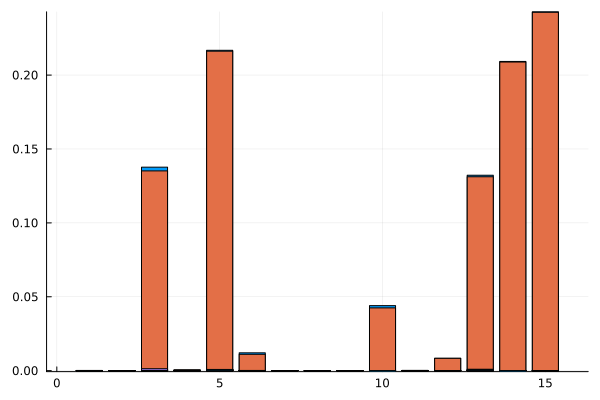

In [29]:
# Import the GS library
using GlobalSensitivity, QuasiMonteCarlo

# Define a function of one input set only for simplicity
function model(theta)

    # Fixed values needed for the solver to work
    u0 = [1.0,1.0,0.0,0.05,0.01] # IVP
    output_times = LinRange(0,24,25) # Solver times
    tspan = (output_times[1],output_times[end]) # End-points for the solver time

    # Run the solver for the system
    prob = ODEProblem(biofilm_predators, u0, tspan, theta) # Define the ODE problem
    sol = solve(prob, Tsit5(), saveat=output_times) # Solve the ODE problem

    # Set the parameter of interest for our outputs to check sensitivity with respect to
    QOI = sol[2,end]

    # Return the quantity of interest
    return QOI

end

theta = [0.21,0.007,0.12,0.09, # growth rates
         0.2,0.5,0.5, # Efficiencies
         1.0,1.0,1.0,0.1, # Half saturations
         0.005,0.01,0.05,0.005] # Attatchment parameters

test = false
if test == true 
    checker = model(theta)
    println(checker)
end

delta = 0.2
samples = 80000
lb = [(1-delta)*theta[i] for i in 1:length(theta)]
ub = [(1+delta)*theta[i] for i in 1:length(theta)]
sampler = GlobalSensitivity.SobolSample()
A,B = QuasiMonteCarlo.generate_design_matrices(samples,lb,ub,sampler)

res1 = gsa(model,Sobol(order=[0,1,2]),A,B)

bar(1:15,res1.ST,legend=false, label="ST")
bar!(1:15,res1.S1,legend=false, label="S1")
bar!(1:15,res1.S2,legend=false, label="S2")
